In [22]:
import typing as t

import pandas as pd
import tensorflow as tf
from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('data/yahoo_stock.csv', parse_dates=['Date'])

<AxesSubplot:>

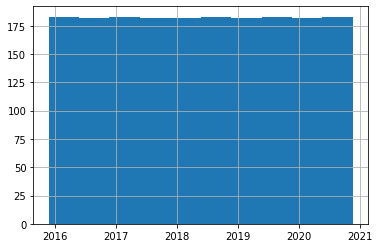

In [4]:
df.Date.hist()

In [5]:
df.Date.max()

Timestamp('2020-11-20 00:00:00')

In [6]:
df['subset'] = pd.qcut(df.Date, q=[.0, .8, .9, 1.], labels=['train', 'val', 'test'])

In [7]:
df

,Date,High,Low,Open,Close,Volume,Adj Close,subset
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088,train
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893,train
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117,train
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117,train
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107,train
...,...,...,...,...,...,...,...,...
1820,2020-11-16,3628.510010,3600.159912,3600.159912,3626.909912,5.281980e+09,3626.909912,test
1821,2020-11-17,3623.110107,3588.679932,3610.310059,3609.530029,4.799570e+09,3609.530029,test
1822,2020-11-18,3619.090088,3567.330078,3612.090088,3567.790039,5.274450e+09,3567.790039,test
1823,2020-11-19,3585.219971,3543.840088,3559.409912,3581.870117,4.347200e+09,3581.870117,test


In [17]:
df['day'] = (df.Date - df.Date.min()).dt.days

In [18]:
df

,Date,High,Low,Open,Close,Volume,Adj Close,subset,day
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088,train,0
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893,train,1
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117,train,2
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117,train,3
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107,train,4
...,...,...,...,...,...,...,...,...,...
1820,2020-11-16,3628.510010,3600.159912,3600.159912,3626.909912,5.281980e+09,3626.909912,test,1820
1821,2020-11-17,3623.110107,3588.679932,3610.310059,3609.530029,4.799570e+09,3609.530029,test,1821
1822,2020-11-18,3619.090088,3567.330078,3612.090088,3567.790039,5.274450e+09,3567.790039,test,1822
1823,2020-11-19,3585.219971,3543.840088,3559.409912,3581.870117,4.347200e+09,3581.870117,test,1823


In [11]:
def _float_feature(value: float) -> tf.train.Feature:
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [19]:
def _int64_feature(value: int) -> tf.train.Feature:
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [12]:
def _string_encode(value: str) -> bytes:
    assert value
    return value.encode("utf-8")

def _string_feature(value: str) -> tf.train.Feature:
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[_string_encode(value)])
    )

In [23]:
def serialize_example(row: t.Dict[str, t.Any]) -> bytes:
    """
    Creates a tf.train.Example message ready to be written to a file.
    """

    features = {
        'High': _float_feature(row['High']),
        'Low': _float_feature(row['Low']),
        'Open': _float_feature(row['Open']),
        'Close': _float_feature(row['Close']),
        'Volume': _float_feature(row['Volume']),
        'Adj Close': _float_feature(row['Adj Close']),
        'subset': _string_feature(row['subset']),
        'day': _int64_feature(row['day']),
    }

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=features))
    message: bytes = example_proto.SerializeToString()
    return message

In [24]:
with tf.io.TFRecordWriter('data/yahoo_stock.tfrecord') as writer:
    for idx, current_row in tqdm(df.iterrows(), total=len(df)):
        example = serialize_example(current_row)
        writer.write(example)

  0%|          | 0/1825 [00:00<?, ?it/s]